In [ ]:
# Merging aggtrade file

In [3]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt


files = glob.glob("aggtrade/*.txt")

dfs = [pd.read_csv(f) for f in files]
agg_trade = pd.concat(dfs).reset_index(drop=True)

print(agg_trade.head())

                                      Time   Price  Quantity  IsMarketMaker  \
0  2025-03-14 00:00:02.764823793 +0530 IST  579.41     0.496           True   
1  2025-03-14 00:00:02.781509697 +0530 IST  579.38     0.013           True   
2    2025-03-14 00:00:02.8057318 +0530 IST  579.38     0.104           True   
3  2025-03-14 00:00:03.902576812 +0530 IST  579.34     0.496           True   
4  2025-03-14 00:00:03.905083833 +0530 IST  579.32     2.739           True   

   NumTrades     M  
0          1  True  
1          1  True  
2          1  True  
3          1  True  
4          2  True  


In [4]:
from datetime import datetime

def clean_time_column(ts):
    ts = ts.replace(' IST', '')
    if '.' in ts:
        prefix, rest = ts.split('.')
        frac_sec, tz = rest.split(' ')
        frac_sec = frac_sec[:6]
        ts = f"{prefix}.{frac_sec} {tz}"
    return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f %z')

agg_trade['Time'] = agg_trade['Time'].apply(clean_time_column)
agg_trade = agg_trade.sort_values('Time').set_index('Time')


In [5]:
agg_trade = agg_trade.sort_index()

In [6]:
#Feature Engineering (aggtrade)


In [7]:
agg_trade['volume_10s'] = agg_trade['Quantity'].rolling('10s').sum()
agg_trade['volume_30s'] = agg_trade['Quantity'].rolling('30s').sum()


In [8]:
agg_trade['vwap_10s'] = (agg_trade['Price'] * agg_trade['Quantity']).rolling('10s').sum() / agg_trade['Quantity'].rolling('10s').sum()


In [9]:
agg_trade['buy_volume'] = agg_trade.apply(
    lambda row: row['Quantity'] if not row['IsMarketMaker'] else 0,
    axis=1
)
agg_trade['sell_volume'] = agg_trade.apply(
    lambda row: row['Quantity'] if row['IsMarketMaker'] else 0,
    axis=1
)
agg_trade['buy_volume_10s'] = agg_trade['buy_volume'].rolling('10s').sum()
agg_trade['sell_volume_10s'] = agg_trade['sell_volume'].rolling('10s').sum()


In [10]:
agg_trade['volume_imbalance'] = agg_trade['buy_volume_10s'] - agg_trade['sell_volume_10s']

In [11]:
agg_trade['mid_price'] = agg_trade['Price']
agg_trade['log_return'] = agg_trade['mid_price']/agg_trade['mid_price'].shift(1)

In [12]:
agg_trade['volatility_10s'] = agg_trade['log_return'].rolling('10s').std()
agg_trade['volatility_30s'] = agg_trade['log_return'].rolling('30s').std()


In [13]:
agg_trade = agg_trade.dropna()


In [14]:
agg_trade.shape

(930637, 17)

In [15]:
agg_trade[['log_return', 'volume_10s', 'volatility_10s', 'volume_imbalance']].describe()


,log_return,volume_10s,volatility_10s,volume_imbalance
count,930637.000000,930637.000000,930637.000000,930637.000000
mean,1.000000,76.125054,0.000056,-2.365677
std,0.000061,186.613089,0.000025,118.485318
min,0.997452,0.015000,0.000000,-1972.567000
25%,0.999983,13.972000,0.000039,-12.103000
50%,1.000000,29.908000,0.000054,-0.679000
75%,1.000017,63.850000,0.000069,10.274000
max,1.003144,3266.755000,0.000379,1917.749000


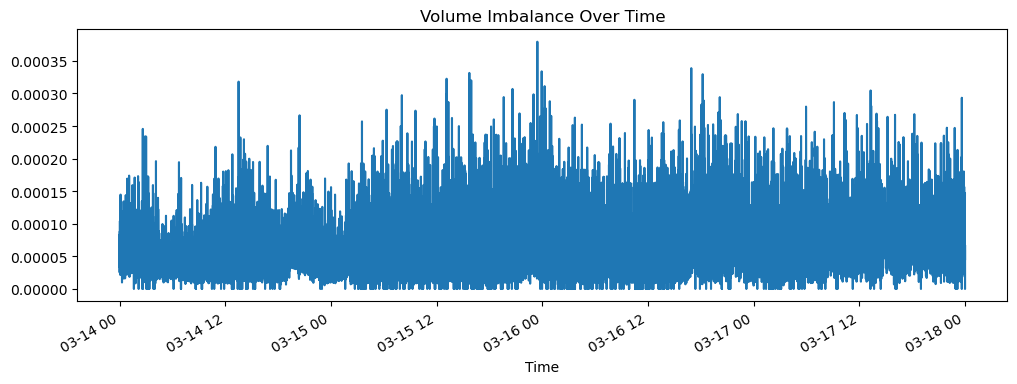

In [16]:
import matplotlib.pyplot as plt

agg_trade['volatility_10s'].plot(title="Volume Imbalance Over Time", figsize=(12,4))
plt.show()


In [17]:
# Merging depth20 file and Feature engineering

In [18]:
file2 = glob.glob('depth20/*.txt')

In [19]:
df2 = [pd.read_csv(f,on_bad_lines='warn') for f in file2]
depth_20 = pd.concat(df2).reset_index(drop=True)

In [20]:
depth_20.head()

,Time,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,AskPriceL16,AskQtyL16,AskPriceL17,AskQtyL17,AskPriceL18,AskQtyL18,AskPriceL19,AskQtyL19,AskPriceL20,AskQtyL20
0,2025-03-14 00:00:02.292522546 +0530 IST,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,579.67,1.151,579.68,0.043,579.69,1.258,579.70,0.911,579.71,2.025
1,2025-03-14 00:00:03.292828523 +0530 IST,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,579.59,0.971,579.60,5.071,579.61,4.894,579.62,1.017,579.63,0.048
2,2025-03-14 00:00:04.292889586 +0530 IST,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,579.62,1.017,579.63,0.048,579.64,9.720,579.65,2.025,579.66,0.365
3,2025-03-14 00:00:05.292551566 +0530 IST,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,579.56,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,7.213
4,2025-03-14 00:00:06.292725093 +0530 IST,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,579.56,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,10.469


In [21]:
depth_20["spread"] = depth_20['BidPriceL1'] - depth_20['AskPriceL1']

In [22]:
depth_20["mid_price"] = (depth_20['BidPriceL1'] + depth_20['AskPriceL1'])/2

bid_qty = [f"BidQtyL{i}" for i  in range(1,6)]
ask_qty = [f"AskQtyL{i}" for i  in range(1,6)]


In [23]:
depth_20[bid_qty] = depth_20[bid_qty].apply(pd.to_numeric, errors='coerce')
depth_20[ask_qty] = depth_20[ask_qty].apply(pd.to_numeric, errors='coerce')

In [24]:
depth_20.fillna(method='ffill', inplace=True)
depth_20.fillna(method='bfill', inplace=True)

C:\Users\sharm\AppData\Local\Temp\ipykernel_12988\504203696.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_20.fillna(method='ffill', inplace=True)
C:\Users\sharm\AppData\Local\Temp\ipykernel_12988\504203696.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_20.fillna(method='bfill', inplace=True)


In [25]:
total_bid = depth_20[bid_qty].sum(axis=1)
total_ask = depth_20[ask_qty].sum(axis=1)

In [26]:
depth_20['obi_5'] = (total_bid - total_ask)/(total_bid + total_ask)

In [27]:

depth_20['cum_bid_qty'] = depth_20[[f'BidQtyL{i}' for i in range(1,21)]].sum(axis = 1)
depth_20['cum_ask_qty'] = depth_20[[f'AskQtyL{i}' for i in range(1,21)]].sum(axis = 1)

depth_20['bid_slope'] = (depth_20['BidPriceL1']-depth_20['BidPriceL20'])/20
depth_20['ask_slope'] = (depth_20['AskPriceL1']-depth_20['AskPriceL20'])/20

In [28]:
depth_20['log_return'] = np.log(depth_20['mid_price']/depth_20['mid_price'].shift(1))

In [29]:
# Remove the trailing ' IST' string
depth_20['Time'] = depth_20['Time'].str.replace(' IST', '', regex=False)

# Parse the cleaned time string
depth_20['Time'] = pd.to_datetime(depth_20['Time'], utc=True)


In [30]:
depth_20['anomaly'] = depth_20['log_return'].abs() > 0.03


In [31]:
depth_20['volatility_10s'] = depth_20['log_return'].rolling(10).std()
depth_20['volatility_30s'] = depth_20['log_return'].rolling(30).std()

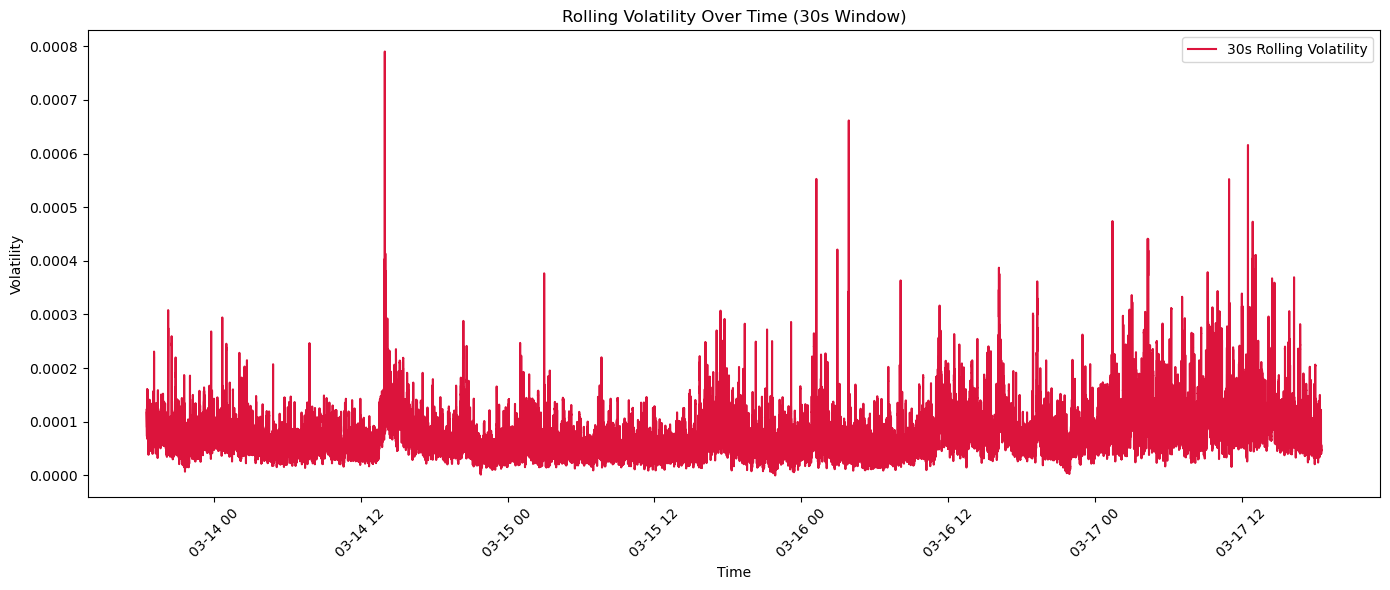

In [32]:
plt.figure(figsize=(14, 6))

plt.plot(depth_20['Time'], depth_20['volatility_30s'], label='30s Rolling Volatility', color='crimson')
plt.title('Rolling Volatility Over Time (30s Window)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
depth_20['microprice'] = (
    depth_20['BidPriceL1'] * depth_20['AskQtyL1'] +
    depth_20['AskPriceL1'] * depth_20['BidQtyL1']
) / (depth_20['BidQtyL1'] + depth_20['AskQtyL1'])


In [34]:
from scipy.stats import skew, kurtosis
depth_20['rolling_skew'] = depth_20['log_return'].rolling(window=30).apply(skew)
depth_20['rolling_kurt'] = depth_20['log_return'].rolling(window=30).apply(kurtosis)



In [35]:
depth_20['log_return_zscore'] = (depth_20['log_return'] - depth_20['log_return'].mean()) / depth_20['log_return'].std()


In [36]:
# Merging both the files 

In [37]:
agg_trade = agg_trade.sort_index()
depth_20 = depth_20.sort_values('Time')


agg_trade = agg_trade.reset_index()


agg_trade['Time'] = agg_trade['Time'].dt.tz_convert('UTC')


merged_df = pd.merge_asof(
    agg_trade,
    depth_20,
    on='Time',
    direction='backward', 
    tolerance=pd.Timedelta('1s')  
)


In [38]:
merged_df.head()

,Time,Price,Quantity,IsMarketMaker,NumTrades,M,volume_10s,volume_30s,vwap_10s,buy_volume,...,bid_slope,ask_slope,log_return_y,anomaly,volatility_10s_y,volatility_30s_y,microprice,rolling_skew,rolling_kurt,log_return_zscore
0,2025-03-13 18:30:02.805731+00:00,579.38,0.104,True,1,True,0.613,0.613,579.404274,0.0,...,0.012,-0.0095,NaN,False,NaN,NaN,579.48,NaN,NaN,NaN
1,2025-03-13 18:30:03.902576+00:00,579.34,0.496,True,1,True,1.109,1.109,579.375528,0.0,...,0.014,-0.0095,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104
2,2025-03-13 18:30:03.905083+00:00,579.32,2.739,True,2,True,3.848,3.848,579.336003,0.0,...,0.014,-0.0095,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104
3,2025-03-13 18:30:03.911723+00:00,579.31,3.565,True,1,True,7.413,7.413,579.323498,0.0,...,0.014,-0.0095,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104
4,2025-03-13 18:30:03.920745+00:00,579.30,5.221,True,2,True,12.634,12.634,579.313787,0.0,...,0.014,-0.0095,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104


In [39]:
features = [
    'log_return_x',
    'log_return_y',
    'volatility_30s_x',
    'volatility_30s_y',
    'volume_10s',
    'volume_imbalance',
    'obi_5',
    'spread',
    'microprice',
    'rolling_skew',
    'rolling_kurt'
]
clustering_data = merged_df[features].dropna()


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_data)

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
regimes = kmeans.fit_predict(clustering_scaled)

merged_df.loc[clustering_data.index, 'regime'] = regimes

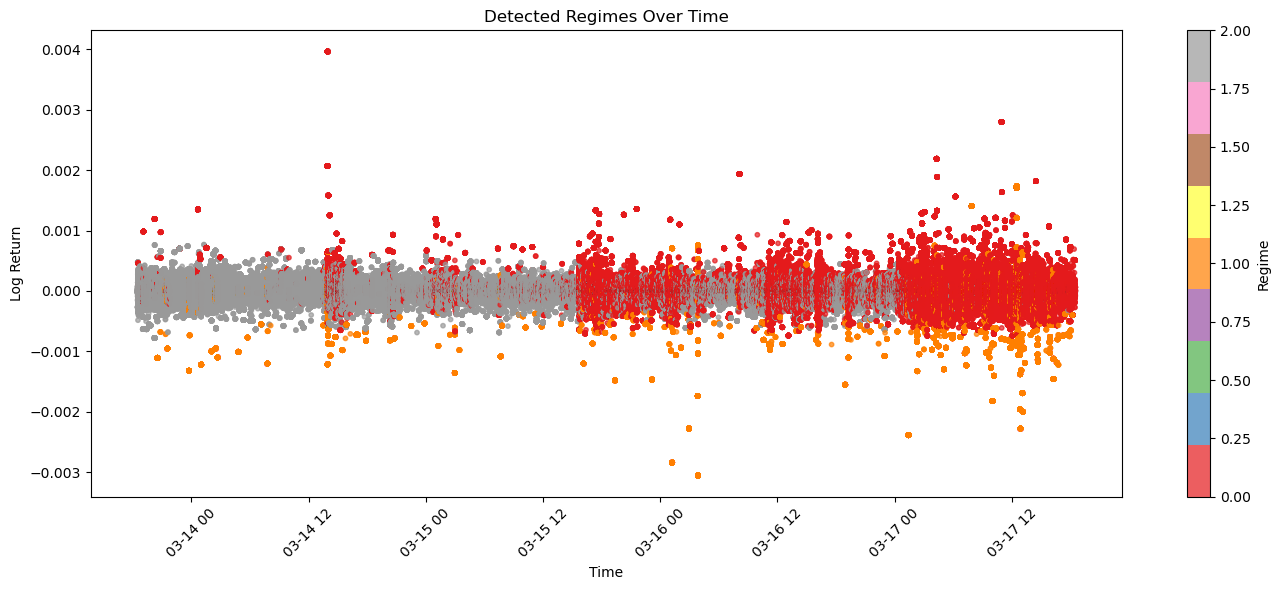

In [44]:

plt.figure(figsize=(14, 6))
scatter = plt.scatter(
    merged_df.loc[clustering_data.index, 'Time'],
    merged_df.loc[clustering_data.index, 'log_return_y'],  
    c=merged_df.loc[clustering_data.index, 'regime'],
    cmap='Set1',
    s=10,
    alpha=0.7
)
plt.title('Detected Regimes Over Time')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.colorbar(scatter, label='Regime')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
clustering_pca = pca.fit_transform(clustering_scaled)

print(f"Original features: {clustering_scaled.shape[1]}, After PCA: {clustering_pca.shape[1]}")



Original features: 11, After PCA: 10


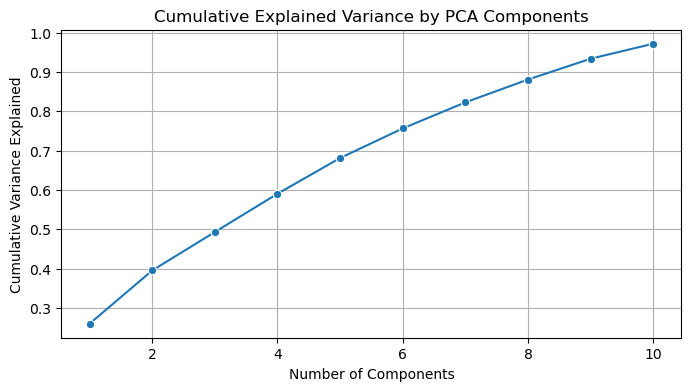

In [46]:
import seaborn as sns 
plt.figure(figsize=(8, 4))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1),
             y=pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

In [48]:
pip install hdbscan


In [49]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=500,     
    min_samples=10,         
    metric='euclidean',
    prediction_data=True
)

cluster_labels = clusterer.fit_predict(clustering_pca)

# Check how many clusters and how much noise
n_clusters = len(np.unique(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = np.sum(cluster_labels == -1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")


Estimated number of clusters: 16
Number of noise points: 159494


In [50]:
cluster_labels

array([15, 15, 15, ..., 15, 15, 15], dtype=int64)

In [51]:


merged_df = merged_df.iloc[:len(cluster_labels)].copy()

# Add cluster labels and timestamps
merged_summary = merged_df.copy()
merged_summary['cluster'] = cluster_labels

# Exclude noise points (-1)
merged_clean = merged_summary[merged_summary['cluster'] != -1]

# Group by cluster
cluster_stats = merged_clean.groupby('cluster').agg(['mean', 'std', 'median'])

# Flatten MultiIndex columns for readability
cluster_stats.columns = ['_'.join(col) for col in cluster_stats.columns]

# Show summary
cluster_stats_sorted = cluster_stats.sort_index()
display(cluster_stats_sorted)


,Time_mean,Time_std,Time_median,Price_mean,Price_std,Price_median,Quantity_mean,Quantity_std,Quantity_median,IsMarketMaker_mean,...,rolling_skew_median,rolling_kurt_mean,rolling_kurt_std,rolling_kurt_median,log_return_zscore_mean,log_return_zscore_std,log_return_zscore_median,regime_mean,regime_std,regime_median
cluster,,,,,,,,,,,,,,,,,,,,,
0,2025-03-17 12:47:17.129712640+00:00,0 days 00:01:10.120363284,2025-03-17 12:46:56.961736960+00:00,632.865798,0.711055,632.990,0.948630,2.102980,0.3290,0.520082,...,0.516047,3.323700,3.769010,1.618499,-0.800662,3.385137,-0.002641,0.120868,0.326142,0.0
1,2025-03-14 13:52:25.603241472+00:00,0 days 00:00:35.688236273,2025-03-14 13:52:20.176527104+00:00,582.557680,0.163793,582.550,0.763545,1.042896,0.5160,0.536098,...,0.161088,1.264856,1.464520,0.901891,0.249636,1.536613,0.285022,1.867692,0.497484,2.0
2,2025-03-17 12:32:12.556261632+00:00,0 days 00:00:31.256366324,2025-03-17 12:32:16.000413952+00:00,632.607261,0.644243,632.700,0.716004,1.385661,0.3290,0.449814,...,0.434063,0.536365,0.927943,0.323556,0.739982,2.815526,0.262606,0.000000,0.000000,0.0
3,2025-03-17 12:01:40.469070848+00:00,0 days 00:00:35.484055118,2025-03-17 12:01:30.862200832+00:00,632.023464,0.544592,632.180,0.695050,1.105608,0.3290,0.532915,...,0.796062,0.873404,1.073730,0.814334,-0.227628,1.939857,-0.267783,0.048896,0.215821,0.0
4,2025-03-17 05:37:28.472111872+00:00,0 days 02:09:38.964529069,2025-03-17 04:29:31.308897536+00:00,632.579615,4.349610,630.140,1.472841,4.851074,0.4110,0.624069,...,-0.431951,3.186270,3.114276,1.739914,-0.273859,1.100016,-0.268620,0.000000,0.000000,0.0
5,2025-03-16 02:57:58.563361792+00:00,0 days 00:00:48.573666908,2025-03-16 02:57:56.433858048+00:00,612.120119,0.140475,612.090,1.730583,6.878306,0.5000,0.476821,...,-1.324739,12.891412,9.506763,9.735584,0.240855,1.192437,0.179837,1.052980,0.777571,1.0
6,2025-03-17 12:49:40.274716160+00:00,0 days 00:01:44.225173976,2025-03-17 12:49:38.052837120+00:00,630.812296,0.595995,630.910,0.826042,1.418439,0.3290,0.678261,...,-2.853675,8.180560,5.750782,7.584184,-4.199238,4.185414,-3.275234,0.699130,0.459035,1.0
7,2025-03-16 01:06:24.535690752+00:00,0 days 14:34:28.120088804,2025-03-15 16:56:13.673214464+00:00,611.692248,10.367087,608.670,1.576583,5.624405,0.3595,0.544964,...,-0.472119,2.398509,2.386970,2.052554,-0.318067,0.980984,-0.002641,0.677536,0.900294,0.0
8,2025-03-16 20:39:56.682331904+00:00,0 days 13:24:49.785543544,2025-03-17 00:47:25.908782080+00:00,617.672266,8.097562,620.910,0.884541,2.040607,0.3290,0.515625,...,0.114951,3.743771,3.780115,2.614223,0.184062,1.218137,0.086160,0.493304,0.862606,0.0


In [52]:
def generate_regime_tags(cluster_stats, features_info):
    tags = []

    for i, row in cluster_stats.iterrows():
        tag = []

        for feature, (low_label, high_label) in features_info.items():
            if feature not in row:
                continue  # skip missing features

            val = row[feature]
            q25, q75 = cluster_stats[feature].quantile([0.25, 0.75])

            if val >= q75:
                tag.append(high_label)
            elif val <= q25:
                tag.append(low_label)

        tags.append(', '.join(tag) if tag else 'Neutral')

    return tags


In [53]:
features_info = {
    'volatility_30s_x_mean':     ('Stable', 'Volatile'),
    'spread':         ('Tight Spread', 'Wide Spread'),
    'volume':         ('Low Volume', 'High Volume'),
    'imbalance':      ('Balanced Flow', 'Skewed Flow'),
    'return_std':     ('Non-Trending', 'Trending'),
}


In [54]:
regime_tags = generate_regime_tags(cluster_stats, features_info)

# Add to the summary table
cluster_stats['regime_description'] = regime_tags

# View
cluster_stats[['regime_description']]


C:\Users\sharm\AppData\Local\Temp\ipykernel_12988\3692939342.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_stats['regime_description'] = regime_tags


,regime_description
cluster,
0,Neutral
1,Stable
2,Volatile
3,Volatile
4,Neutral
5,Neutral
6,Volatile
7,Neutral
8,Stable


<module 'matplotlib.pyplot' from 'D:\\downloads\\anaconda\\Lib\\site-packages\\matplotlib\\pyplot.py'>

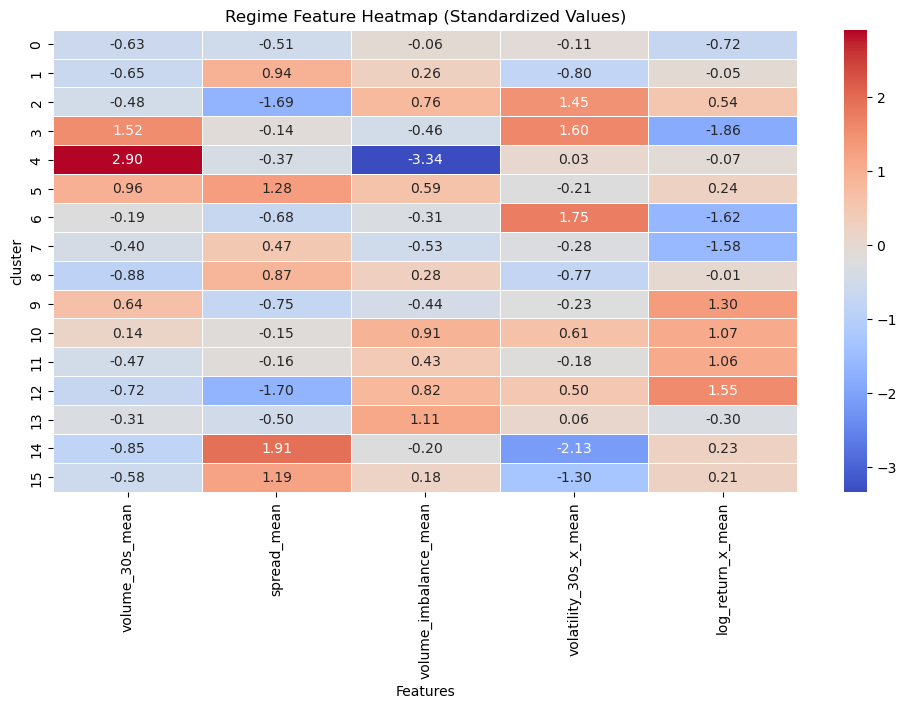

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Choose features to visualize
features_to_plot = [
    'volume_30s_mean',
    'spread_mean',
    'volume_imbalance_mean',
    'volatility_30s_x_mean',
    'log_return_x_mean']

# Step 2: Subset + scale data
heatmap_data = cluster_stats[features_to_plot].copy()
scaler = StandardScaler()
heatmap_scaled = scaler.fit_transform(heatmap_data)
heatmap_scaled_df = pd.DataFrame(heatmap_scaled, index=cluster_stats.index, columns=features_to_plot)

# Step 3: Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_scaled_df, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, linewidths=0.5)
plt.title("Regime Feature Heatmap (Standardized Values)")
plt.xlabel("Features")
plt


C:\Users\sharm\AppData\Local\Temp\ipykernel_12988\131238502.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
D:\downloads\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


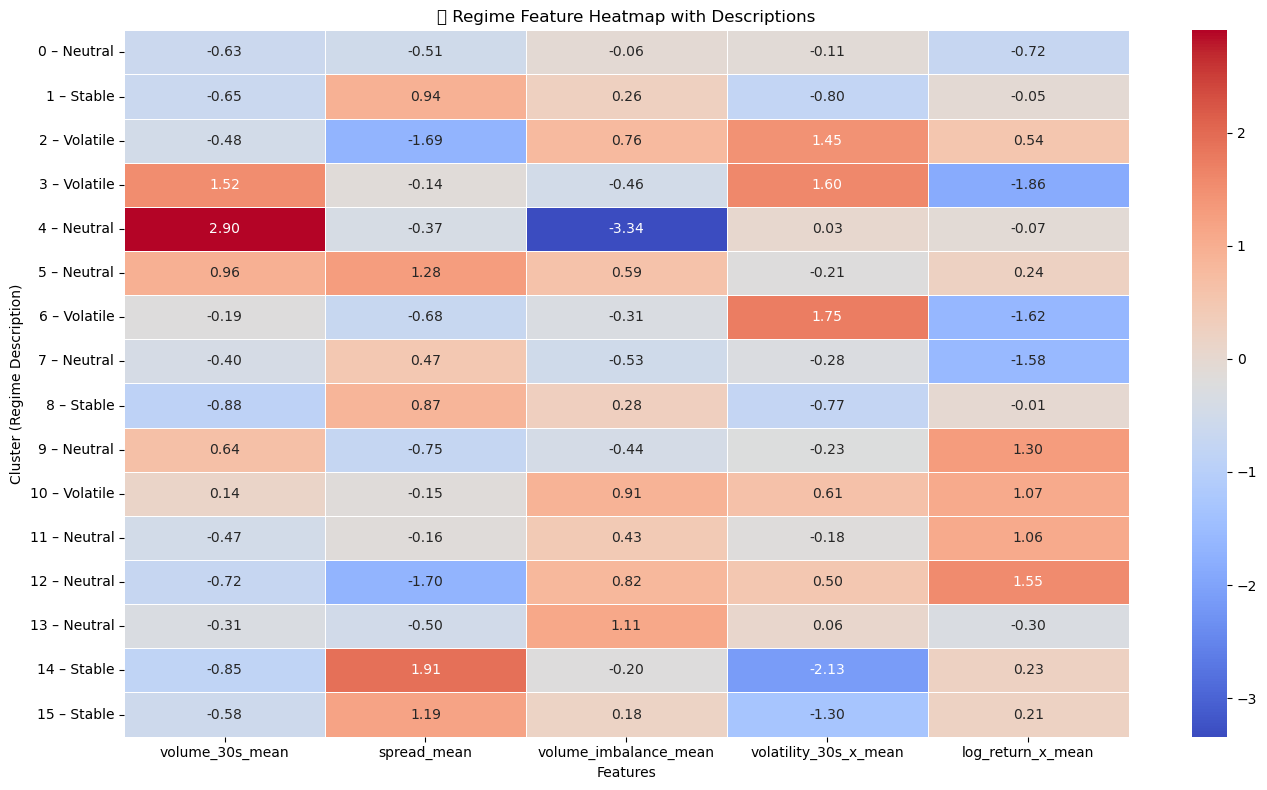

In [56]:
# Step 1: Make new index with cluster number + regime tag
pretty_index = [
    f"{i} – {desc}" for i, desc in zip(cluster_stats.index, cluster_stats['regime_description'])
]

# Step 2: Set this index on the heatmap DataFrame
heatmap_scaled_df.index = pretty_index

# Step 3: Plot with prettier labels
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_scaled_df,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    cbar=True,
    linewidths=0.5
)
plt.title("📈 Regime Feature Heatmap with Descriptions")
plt.xlabel("Features")
plt.ylabel("Cluster (Regime Description)")
plt.tight_layout()
plt.show()


In [57]:
from sklearn.mixture import GaussianMixture

# Step 1: Choose number of components (clusters)
n_components = 10  # Start with 10 — you can tune this

# Step 2: Fit GMM
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(clustering_pca)
merged_df_trimmed = merged_df.copy()

# Step 3: Assign GMM cluster labels to your main DataFrame
merged_df_trimmed['gmm_cluster'] = gmm_labels


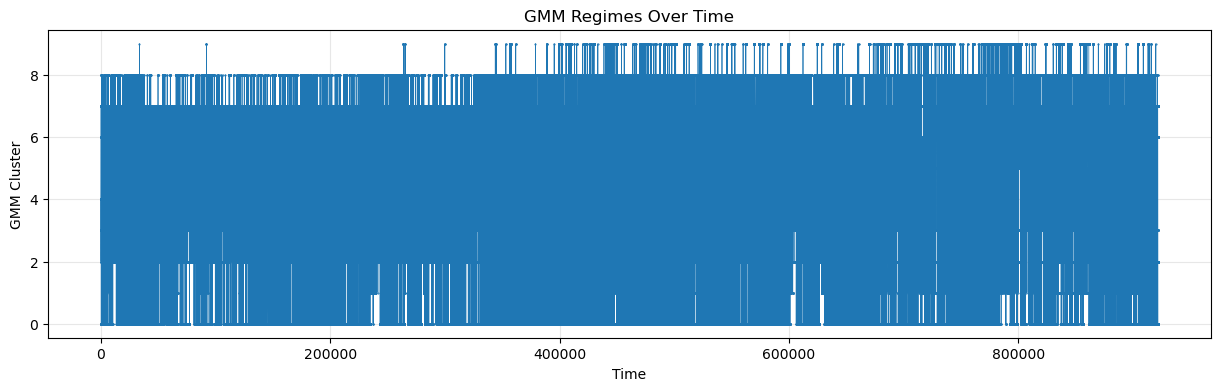

In [58]:
plt.figure(figsize=(15, 4))
plt.plot(merged_df_trimmed.index, merged_df_trimmed['gmm_cluster'], lw=0.5, marker='.', markersize=1)
plt.title('GMM Regimes Over Time')
plt.xlabel('Time')
plt.ylabel('GMM Cluster')
plt.grid(True, alpha=0.3)
plt.show()


In [59]:
merged_df_trimmed.head()

,Time,Price,Quantity,IsMarketMaker,NumTrades,M,volume_10s,volume_30s,vwap_10s,buy_volume,...,log_return_y,anomaly,volatility_10s_y,volatility_30s_y,microprice,rolling_skew,rolling_kurt,log_return_zscore,regime,gmm_cluster
0,2025-03-13 18:30:02.805731+00:00,579.38,0.104,True,1,True,0.613,0.613,579.404274,0.0,...,NaN,False,NaN,NaN,579.48,NaN,NaN,NaN,NaN,4
1,2025-03-13 18:30:03.902576+00:00,579.34,0.496,True,1,True,1.109,1.109,579.375528,0.0,...,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104,NaN,4
2,2025-03-13 18:30:03.905083+00:00,579.32,2.739,True,2,True,3.848,3.848,579.336003,0.0,...,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104,NaN,7
3,2025-03-13 18:30:03.911723+00:00,579.31,3.565,True,1,True,7.413,7.413,579.323498,0.0,...,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104,NaN,4
4,2025-03-13 18:30:03.920745+00:00,579.30,5.221,True,2,True,12.634,12.634,579.313787,0.0,...,-0.000138,False,NaN,NaN,579.40,NaN,NaN,-1.545104,NaN,4


In [60]:
merged_df_trimmed['hdbscan_cluster'] = cluster_labels  


In [61]:
print(merged_df_trimmed.index[:5])
print(merged_df_trimmed.index[-5:])


RangeIndex(start=0, stop=5, step=1)
RangeIndex(start=921680, stop=921685, step=1)


In [62]:
merged_df_trimmed['Time'] = merged_df.loc[merged_df_trimmed.index, 'Time']


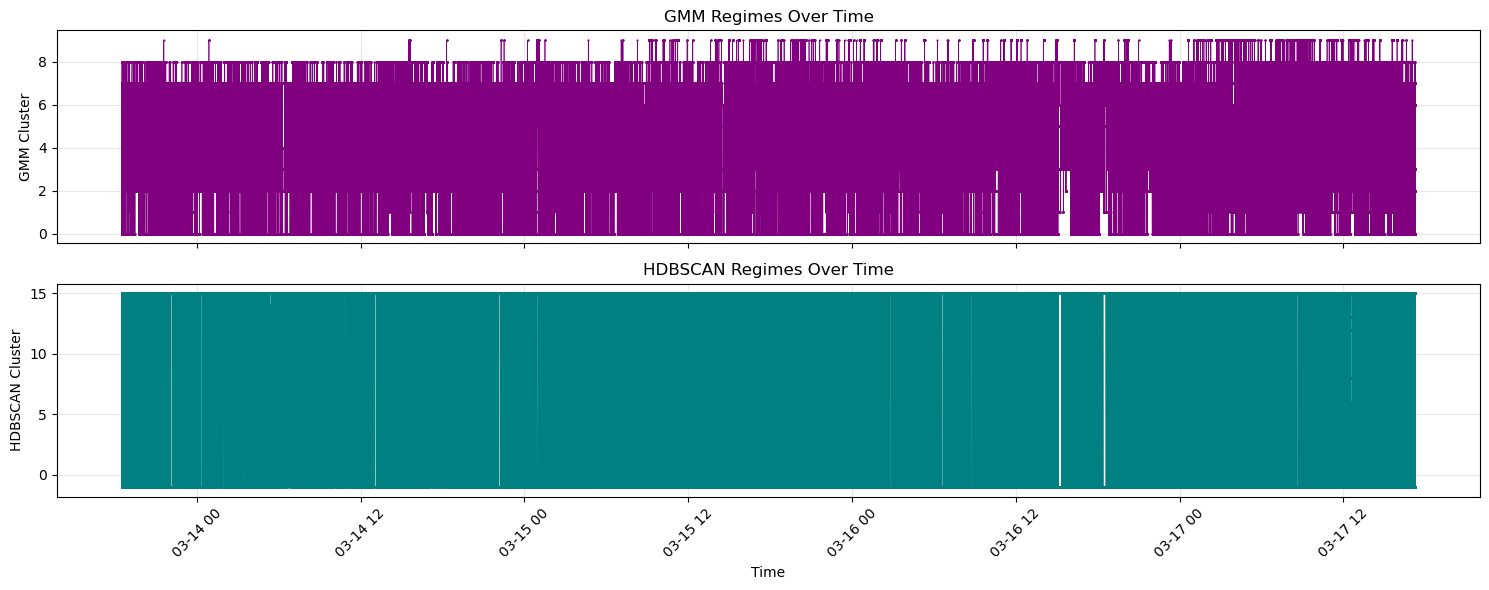

In [63]:


fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

axes[0].plot(
    merged_df_trimmed['Time'], 
    merged_df_trimmed['gmm_cluster'],
    lw=0.5, marker='.', markersize=1, color='purple'
)
axes[0].set_title('GMM Regimes Over Time')
axes[0].set_ylabel('GMM Cluster')
axes[0].grid(alpha=0.3)

axes[1].plot(
    merged_df_trimmed['Time'],
    merged_df_trimmed['hdbscan_cluster'],
    lw=0.5, marker='.', markersize=1, color='teal'
)
axes[1].set_title('HDBSCAN Regimes Over Time')
axes[1].set_ylabel('HDBSCAN Cluster')
axes[1].set_xlabel('Time')
axes[1].grid(alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


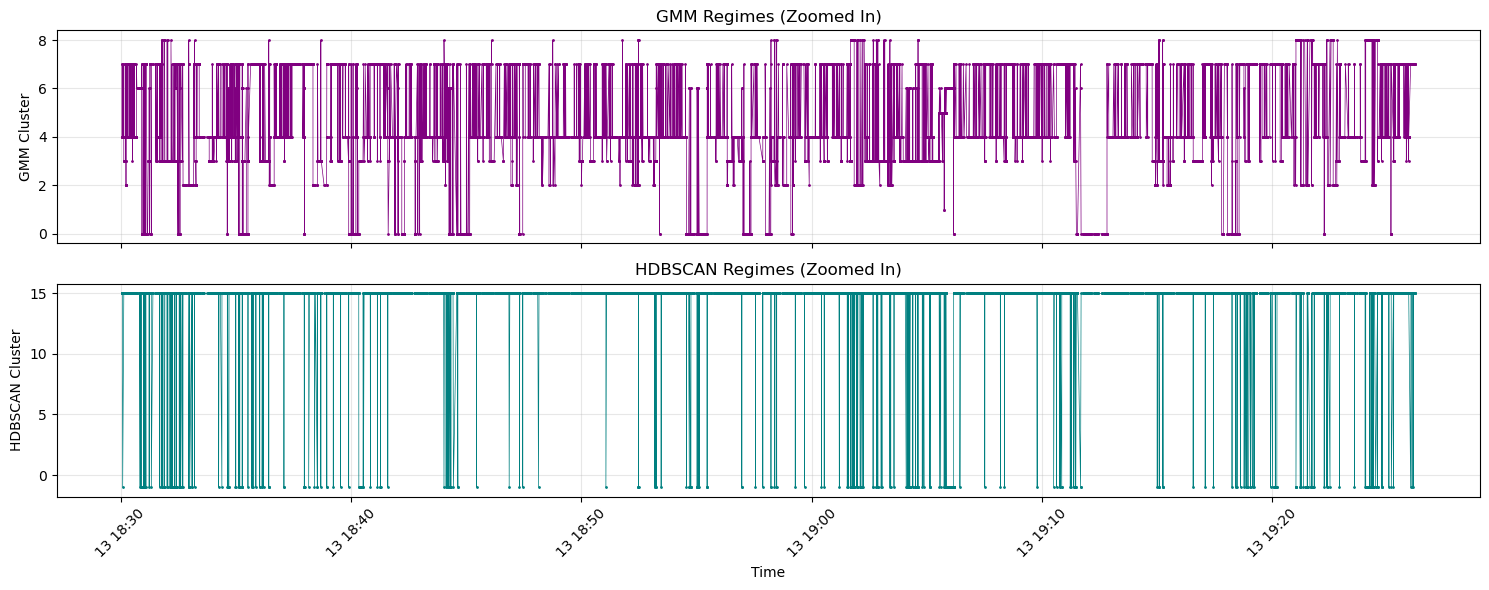

In [64]:
# Zoom range (first 10k rows)
zoom_range = slice(0, 10000)

fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

# GMM Cluster over Time
axes[0].plot(
    merged_df_trimmed.iloc[zoom_range]['Time'],
    merged_df_trimmed.iloc[zoom_range]['gmm_cluster'],
    lw=0.5, marker='.', markersize=2, color='purple'
)
axes[0].set_title('GMM Regimes (Zoomed In)')
axes[0].set_ylabel('GMM Cluster')
axes[0].grid(alpha=0.3)

# HDBSCAN Cluster over Time
axes[1].plot(
    merged_df_trimmed.iloc[zoom_range]['Time'],
    merged_df_trimmed.iloc[zoom_range]['hdbscan_cluster'],
    lw=0.5, marker='.', markersize=2, color='teal'
)
axes[1].set_title('HDBSCAN Regimes (Zoomed In)')
axes[1].set_ylabel('HDBSCAN Cluster')
axes[1].set_xlabel('Time')
axes[1].grid(alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [68]:
import pickle

# Bundle everything in a dict
save_dict = {
    'merged_df_trimmed': merged_df_trimmed,
    'clustering_pca': clustering_pca,
    'hdbscan_model': clusterer,
    'gmm_model': gmm,
    'hdbscan_labels': cluster_labels,
    'gmm_labels': gmm_labels,
    'cluster_stats': cluster_stats
}

# Save to file
with open("regime_detection_progress.pkl", "wb") as f:
    pickle.dump(save_dict, f)


In [72]:
import numpy as np
from sklearn.metrics import silhouette_score

# Adjust sample size as needed
sample_size = 5000

# Function to safely sample data and compute silhouette score
def fast_silhouette_score(X, labels, sample_size=5000):
    # Filter out noise points (-1) for HDBSCAN
    valid_indices = labels != -1
    X_valid = X[valid_indices]
    labels_valid = labels[valid_indices]

    if len(X_valid) < sample_size:
        sample_size = len(X_valid)

    # Random sample
    sample_indices = np.random.choice(len(X_valid), size=sample_size, replace=False)
    sil_score = silhouette_score(X_valid[sample_indices], labels_valid[sample_indices])
    return sil_score

# Example usage:
# Assuming you already have:
# X_pca, kmeans_labels, gmm_labels, hdbscan_labels

print("KMeans Silhouette (sampled):", fast_silhouette_score(clustering_pca, regimes))
print("GMM Silhouette (sampled):", fast_silhouette_score(clustering_pca, gmm_labels))
print("HDBSCAN Silhouette (sampled):", fast_silhouette_score(clustering_pca, cluster_labels))


KMeans Silhouette (sampled): 0.20583411757441272
GMM Silhouette (sampled): 0.023617930974869524
HDBSCAN Silhouette (sampled): 0.32104954175336947


In [76]:
print(cluster_labels)

[15 15 15 ... 15 15 15]


In [80]:
merged_clustered = merged_df.copy()
merged_clustered['cluster'] = cluster_labels  # use HDBSCAN labels

# Exclude noise (-1), if present
merged_clustered_filtered = merged_clustered[merged_clustered['cluster'] != -1]

cluster_summary = merged_clustered_filtered.groupby('cluster')[features].mean()
print(cluster_summary)


         log_return_x  log_return_y  volatility_30s_x  volatility_30s_y  \
cluster                                                                   
0            0.999998     -0.000071          0.000069          0.000122   
1            0.999999      0.000023          0.000061          0.000124   
2            1.000001      0.000066          0.000085          0.000185   
3            0.999995     -0.000020          0.000087          0.000204   
4            0.999999     -0.000024          0.000070          0.000113   
5            1.000000      0.000022          0.000067          0.000204   
6            0.999995     -0.000376          0.000089          0.000199   
7            0.999995     -0.000028          0.000067          0.000101   
8            0.999999      0.000017          0.000061          0.000084   
9            1.000003      0.000005          0.000067          0.000160   
10           1.000002      0.000213          0.000076          0.000190   
11           1.000002    

In [82]:
regime_labels = {
    0: "Quiet & Slightly Bearish",
    1: "Stable & Low Volume",
    2: "Calm Uptrend",
    3: "Bullish Momentum",
    4: "High Volume Dump",
    5: "Panic Selling / Flash Crash",
    6: "High Volatility Selloff",
    7: "Liquidity Compression",
    8: "Stable Market",
    9: "Trend-Building",
    10: "Strong Bull Trend",
    11: "Volatile w/ Bearish Bias",
    12: "Choppy Positive Drift",
    13: "Sideways Transition",
    14: "Quiet Accumulation",
    15: "Neutral, Low Activity"
}


In [86]:
merged_df['cluster']= cluster_labels
merged_filtered = merged_df[merged_df['cluster'] != -1].copy()

# Map human-readable labels
merged_filtered['regime_label'] = merged_filtered['cluster'].map(regime_labels)

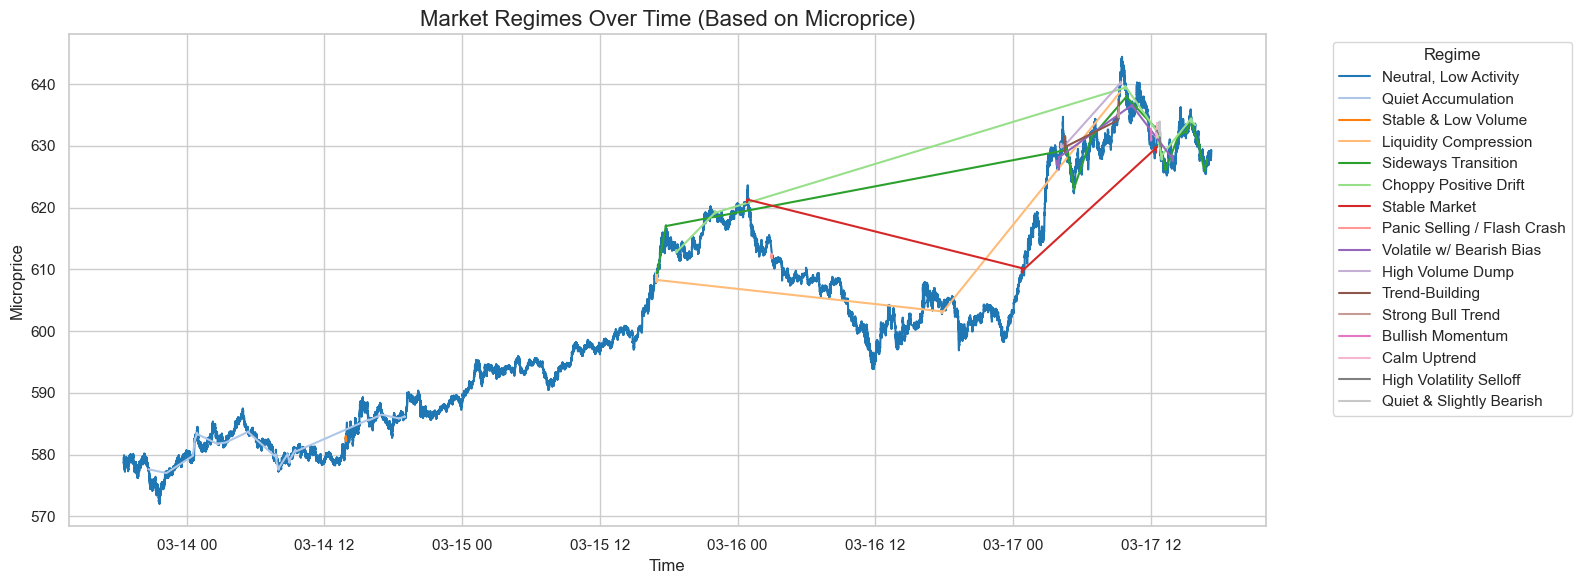

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# Sort by time if needed
merged_filtered = merged_filtered.sort_index()

# Plot microprice or another relevant time series
sns.lineplot(data=merged_filtered, x=merged_filtered['Time'], y="microprice", hue="regime_label", palette="tab20", linewidth=1.5)

# Enhance legend and formatting
plt.title("Market Regimes Over Time (Based on Microprice)", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Microprice")
plt.legend(title="Regime", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


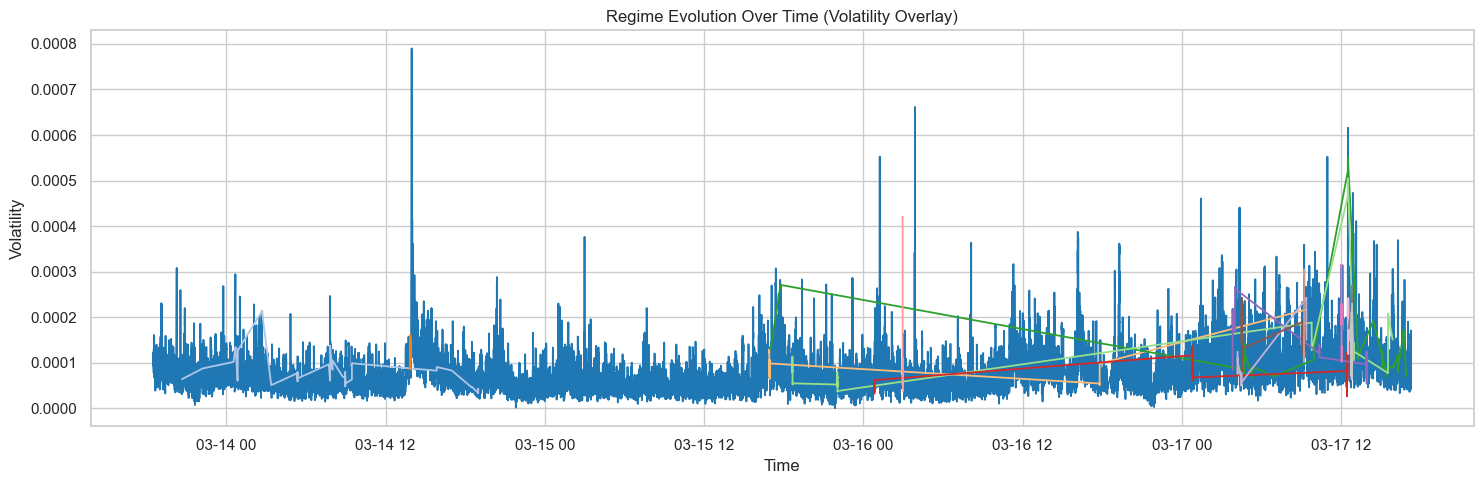

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.lineplot(data=merged_filtered, x=merged_filtered["Time"], y="volatility_30s_y", hue="regime_label", palette="tab20", linewidth=1.3, legend=None)
plt.title("Regime Evolution Over Time (Volatility Overlay)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()


In [122]:
pip install umap-learn


   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ------------------------------------ --- 81.9/88.8 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 88.8/88.8 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


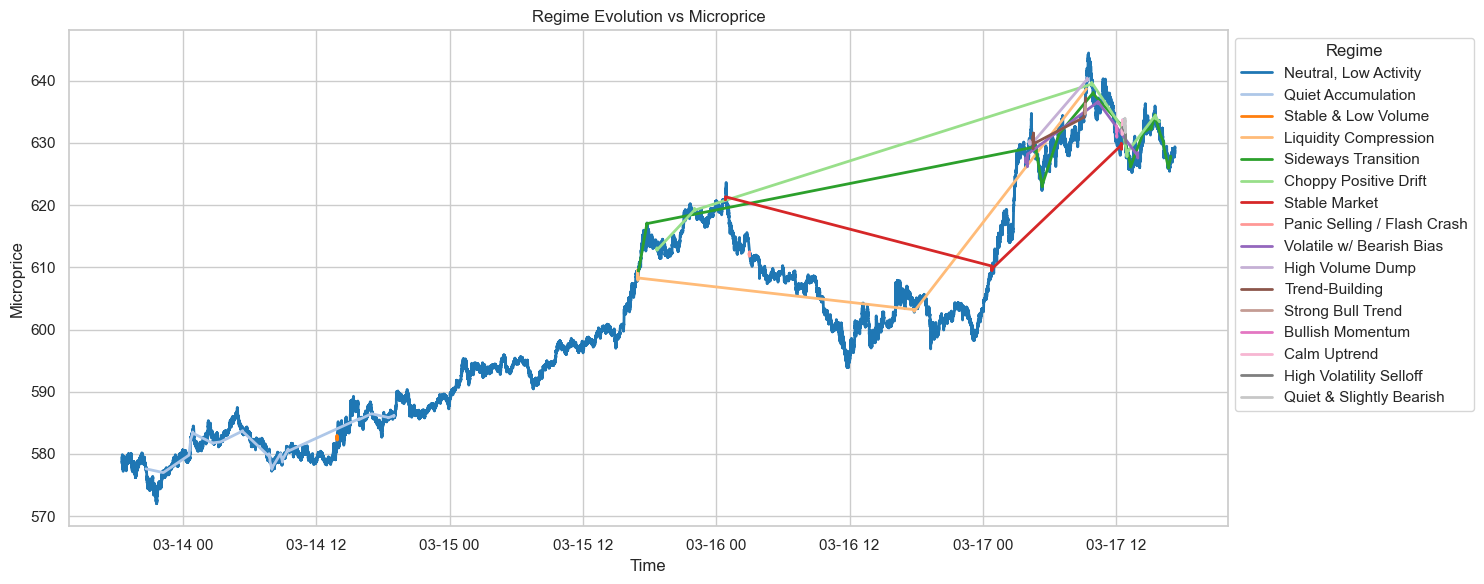

In [140]:

plt.figure(figsize=(15, 6))
sns.lineplot(data=merged_filtered, x=merged_filtered['Time'], y='microprice', hue='regime_label', palette='tab20', linewidth=2)
plt.title("Regime Evolution vs Microprice")
plt.xlabel("Time")
plt.ylabel("Microprice")
plt.legend(title="Regime", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


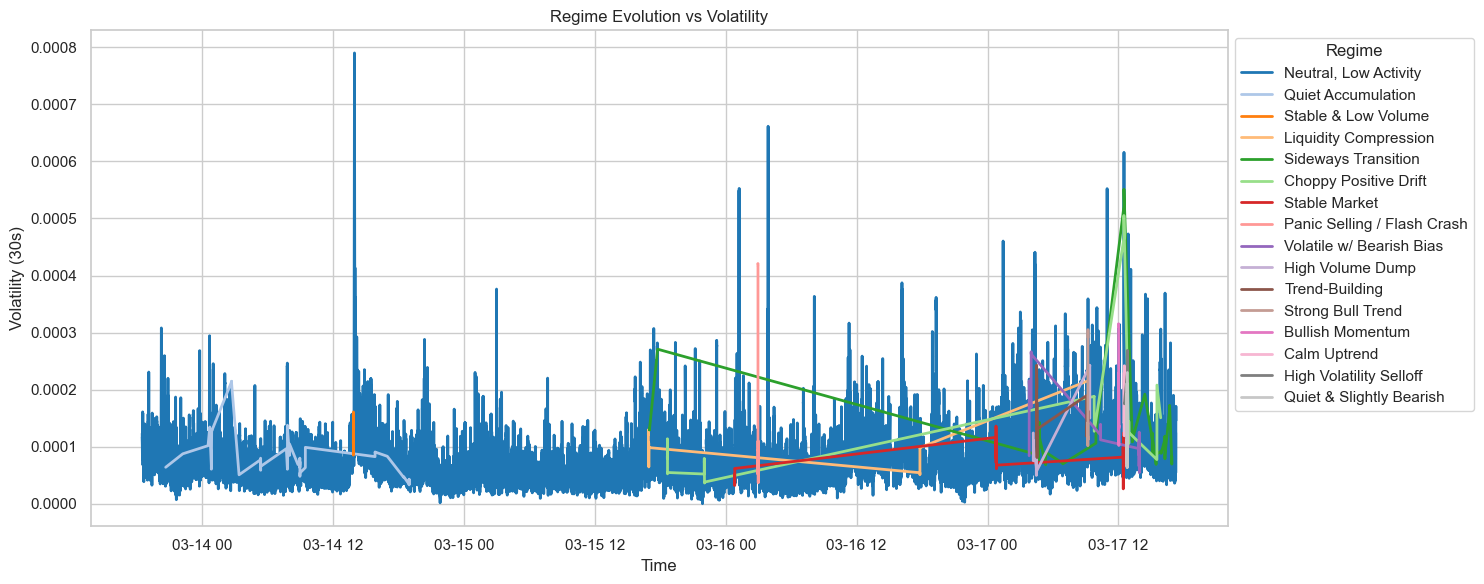

In [143]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=merged_filtered, x=merged_filtered['Time'], y='volatility_30s_y', hue='regime_label', palette='tab20', linewidth=2)
plt.title("Regime Evolution vs Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility (30s)")
plt.legend(title="Regime", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [145]:
# Shift the regime labels to see the next regime
merged_filtered['next_regime'] = merged_filtered['regime_label'].shift(-1)

# Drop the last row as it will have NaN for 'next_regime'
merged_filtered = merged_filtered.dropna(subset=['next_regime'])

# Create a transition count matrix
transition_counts = pd.crosstab(merged_filtered['regime_label'], merged_filtered['next_regime'])

# Normalize the matrix to get transition probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Display the transition probability matrix
print(transition_matrix)


next_regime                  Bullish Momentum  Calm Uptrend  \
regime_label                                                  
Bullish Momentum                     0.998433      0.000000   
Calm Uptrend                         0.000000      0.998761   
Choppy Positive Drift                0.000000      0.000000   
High Volatility Selloff              0.000000      0.000000   
High Volume Dump                     0.000000      0.000000   
Liquidity Compression                0.000000      0.000000   
Neutral, Low Activity                0.000001      0.000001   
Panic Selling / Flash Crash          0.000000      0.000000   
Quiet & Slightly Bearish             0.000000      0.000000   
Quiet Accumulation                   0.000000      0.000000   
Sideways Transition                  0.000000      0.000000   
Stable & Low Volume                  0.000000      0.000000   
Stable Market                        0.000000      0.000000   
Strong Bull Trend                    0.000000      0.00